# My Favorite Pet

Goal:

To train 2 binary classification models: one for dogs and one for cats. And to combine them together to have a multiclass classification model.

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
import random
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [10]:
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d anirudhg15/mammals-classification
# !unzip /content/mammals-classification.zip

# Sources

- https://www.tensorflow.org/tutorials/images/classification

- https://www.kaggle.com/code/o07rohitjj/mammals-classification-with-efficientnet

- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# Data Exploration

In [2]:
data_path = 'mammals'
mammals = [f.name for f in os.scandir(data_path) if f.is_dir()]
mammals

['bear', 'cat', 'dog', 'elephant', 'goat', 'horse', 'lion', 'tiger', 'wolf']

### Separate dog data

In [3]:
dog_root = data_path + '/dog/'
dog_url = [dog_root+dog for dog in os.listdir(dog_root)]
dog_data = [Image.open(dog) for dog in dog_url]

## Example of how to read the image as numpy array

In [4]:
dog_1 = Image.open(dog_url[1])
# "thumbnail" is to shrink the image wihile keeping the aspect ratio
dog_1.thumbnail((100, 100))
dog_1.show()

In [5]:
# "reduced" is to shrink the image resolution by dividing the given value
dog_1_re = dog_1.reduce((10, 10))
dog_1_re.show()

In [6]:
dog_0 = Image.open(dog_url[0])
# "resize" is to shrink the image to a given size
dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)
dog_0_r.show()

C:\Users\rulin\AppData\Local\Temp\ipykernel_6220\305650333.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)


# Data Preparation

### Loading data into a pandas data frame with one column of file paths and one column of labels

In [7]:
direc = Path('mammals')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,mammals\bear\00000028.JPG,bear
1,mammals\goat\00000068.jpg,goat
2,mammals\cat\00000075.jpg,cat
3,mammals\dog\00000088.jpg,dog
4,mammals\tiger\00000056.jpg,tiger


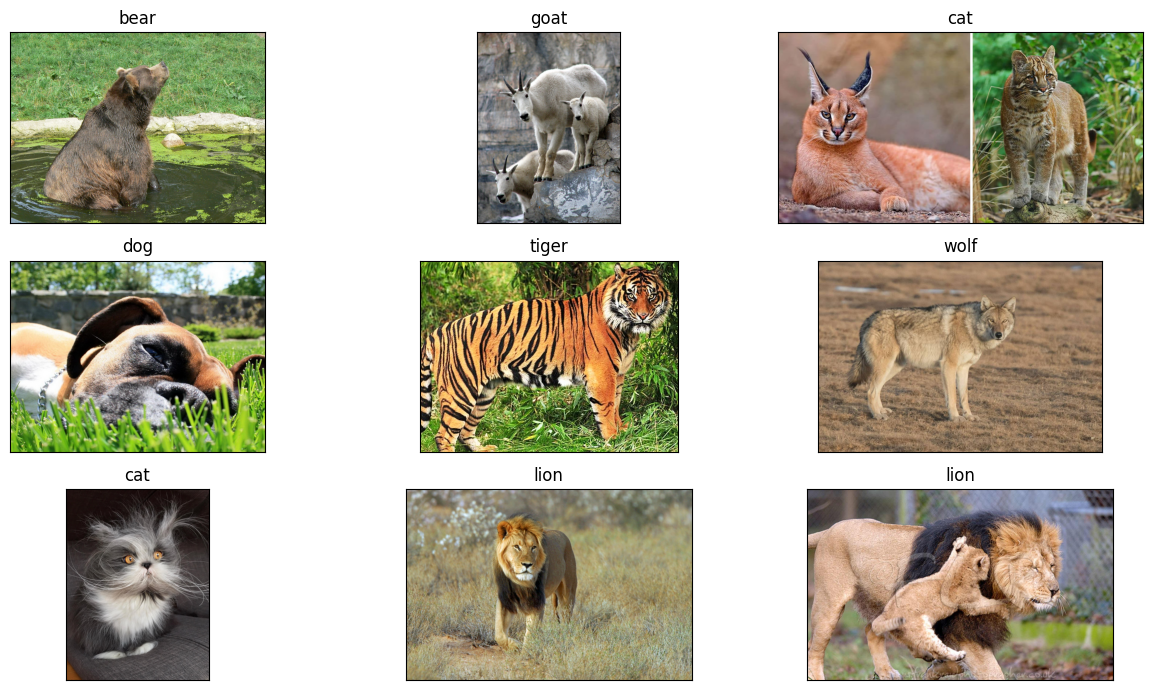

In [8]:
f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

### Split training data

In [9]:
def divide_data(img_df, dog_or_cat='dog'):
    if dog_or_cat not in ['dog', 'cat']:
        raise ValueError("Invalid value for dog_or_cat. It should be either 'dog' or 'cat'.")
    main_animal_df = img_df[img_df.Labels==dog_or_cat]
    half = img_df.shape[0] // 2
    if dog_or_cat == 'dog':
        slice_animals = slice(0, half)
    else:
        slice_animals = slice(half, -1)
    all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])][slice_animals].sample(n = main_animal_df.shape[0], random_state=42)
    df = pd.concat([main_animal_df, all_animals_df]).sample(frac = 1, random_state=42)
    df['y'] = df.Labels == dog_or_cat
    return df

In [10]:
dog_train = divide_data(img_df, dog_or_cat='dog')
print(type(dog_train))
print('Training set size:', dog_train.shape)
print('Training set statistics', dog_train.Labels.value_counts())
print(dog_train.y.value_counts())
dog_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics Labels
dog         95
bear        18
goat        17
lion        15
tiger       13
elephant    12
wolf        11
horse        9
Name: count, dtype: int64
y
False    95
True     95
Name: count, dtype: int64


,FilePaths,Labels,y
5,mammals\wolf\00000001.jpg,wolf,False
87,mammals\goat\00000087.jpg,goat,False
332,mammals\goat\00000027.jpg,goat,False
568,mammals\dog\00000059.jpg,dog,True
512,mammals\tiger\00000058.jpg,tiger,False


In [13]:
cat_train = divide_data(img_df, dog_or_cat='cat')
print(type(cat_train))
print('Training set size:', cat_train.shape)
print('Training set statistics', cat_train.Labels.value_counts())
print(cat_train.y.value_counts())
cat_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics Labels
cat         95
tiger       19
lion        19
elephant    17
wolf        16
bear         8
horse        8
goat         8
Name: count, dtype: int64
y
False    95
True     95
Name: count, dtype: int64


,FilePaths,Labels,y
581,mammals\tiger\00000035.jpg,tiger,False
715,mammals\bear\00000046.jpg,bear,False
748,mammals\elephant\00000054.jpg,elephant,False
525,mammals\cat\00000036.jpg,cat,True
586,mammals\lion\00000093.jpg,lion,False


## Resize images by padding

In [14]:
def resize_image(pil_img, new_width=100, new_height=100, color='white'):
    right = left = top = bottom = 0
    width, height = pil_img.size
    if width > new_width and height > new_height:
        return pil_img.resize((100, 100))
    elif width < new_width:
        w = new_width - width
        left = w // 2
        right = w - left
    elif height < new_height:
        h = new_height - height
        top = h // 2
        bottom = h - top

    # new_width = width + right + left
    # new_height = height + top + bottom
    img_pad = Image.new(pil_img.mode, (new_width, new_height), color)
    img_pad.paste(pil_img, (left, top), mask=pil_img)
    return img_pad

In [15]:
# pass all the input samples to the a new pandas.DataFrame where the first column is the image matrix and the second column is the labels the third column is the target binary values
# resize the images, suppose the size of every given image is greater than 100 x 100
def read_image_matrix(img_path, new_size=(100, 100)):
    # read the image path fron the first column of the dataframe then read the image as a matrix
    try:
        img = Image.open(img_path)
        img_resize = img.resize(size=new_size)
        img_matrix = np.array(img_resize)
        return img_matrix
    except:
        return None

dog_train['Matrix'] = dog_train['FilePaths'].apply(read_image_matrix)
cat_train['Matrix'] = cat_train['FilePaths'].apply(read_image_matrix)

In [16]:
display(dog_train.head(), cat_train.head())

,FilePaths,Labels,y,Matrix
5,mammals\wolf\00000001.jpg,wolf,False,"[[[111, 96, 82], [122, 106, 86], [140, 118, 93..."
87,mammals\goat\00000087.jpg,goat,False,"[[[60, 35, 14], [53, 33, 9], [76, 55, 20], [73..."
332,mammals\goat\00000027.jpg,goat,False,"[[[26, 20, 14], [26, 20, 13], [27, 22, 15], [3..."
568,mammals\dog\00000059.jpg,dog,True,"[[[205, 184, 98], [204, 180, 97], [203, 176, 9..."
512,mammals\tiger\00000058.jpg,tiger,False,"[[[142, 143, 116], [170, 170, 140], [160, 160,..."


,FilePaths,Labels,y,Matrix
581,mammals\tiger\00000035.jpg,tiger,False,"[[[41, 29, 19], [45, 31, 20], [52, 34, 21], [5..."
715,mammals\bear\00000046.jpg,bear,False,"[[[220, 235, 254], [220, 235, 254], [220, 235,..."
748,mammals\elephant\00000054.jpg,elephant,False,"[[[69, 93, 123], [54, 86, 113], [65, 112, 128]..."
525,mammals\cat\00000036.jpg,cat,True,"[[[173, 198, 149], [153, 165, 141], [152, 173,..."
586,mammals\lion\00000093.jpg,lion,False,"[[[139, 182, 96], [117, 158, 63], [219, 206, 1..."


In [17]:
def clean_data(data):
  i = 0
  for img in data['Matrix']:
      if np.array(img).shape not in [(100, 100, 3)]:
          i += 1
  print('Number of invaid images: ', i)

  # Clean the data by removing the damaged images
  data = data[data['Matrix'].apply(lambda x: np.array(x).shape == (100, 100, 3))]
  return data.reset_index(drop=True)

def transform_data(data):
  img_mat = pd.DataFrame({'image_matrix': data['Matrix'], 'label': data['y']})
  img_mat['label'] = img_mat['label'].astype(int)
  return img_mat


In [18]:
print('Cat')
cat_train = clean_data(cat_train)
print('Dog')
dog_train = clean_data(dog_train)

Cat
Number of invaid images:  0
Dog
Number of invaid images:  4


In [19]:
print('Cat')
cat_img_mat = transform_data(cat_train)
print('Dog')
dog_img_mat = transform_data(dog_train)
display(cat_img_mat.head(), dog_img_mat.head())

Cat
Dog


,image_matrix,label
0,"[[[41, 29, 19], [45, 31, 20], [52, 34, 21], [5...",0
1,"[[[220, 235, 254], [220, 235, 254], [220, 235,...",0
2,"[[[69, 93, 123], [54, 86, 113], [65, 112, 128]...",0
3,"[[[173, 198, 149], [153, 165, 141], [152, 173,...",1
4,"[[[139, 182, 96], [117, 158, 63], [219, 206, 1...",0


,image_matrix,label
0,"[[[111, 96, 82], [122, 106, 86], [140, 118, 93...",0
1,"[[[60, 35, 14], [53, 33, 9], [76, 55, 20], [73...",0
2,"[[[26, 20, 14], [26, 20, 13], [27, 22, 15], [3...",0
3,"[[[205, 184, 98], [204, 180, 97], [203, 176, 9...",1
4,"[[[142, 143, 116], [170, 170, 140], [160, 160,...",0


In [20]:
# check the statistics
def check_stats(img_mat):
  print('Statistics: ', img_mat.label.value_counts())
  print('Size of processed images: ', img_mat.iloc[1]['image_matrix'].shape)
  # print('An image matrix example: ', img_mat.iloc[1]['image_matrix'])

print('Cat')
check_stats(cat_img_mat)
print('Dog')
check_stats(dog_img_mat)

Cat
Statistics:  label
0    95
1    95
Name: count, dtype: int64
Size of processed images:  (100, 100, 3)
Dog
Statistics:  label
0    93
1    93
Name: count, dtype: int64
Size of processed images:  (100, 100, 3)


one dog image and one non-dog image are removed due to damage reason

## Train a Convolutional Neural Network for Classification



### Prepare the training data

In [33]:
X_train_cat = np.stack(cat_img_mat['image_matrix'].values)
X_train_cat = X_train_cat.astype('float32') / 255.0
X_train_cat = X_train_cat.reshape(-1, 100, 100, 3)

y_train_cat = cat_img_mat['label'].values

In [21]:
X_train_dog = np.stack(dog_img_mat['image_matrix'].values)
X_train_dog = X_train_dog.astype('float32') / 255.0
X_train_dog = X_train_dog.reshape(-1, 100, 100, 3)

y_train_dog = dog_img_mat['label'].values

### Build CNN model

In [26]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
reset_seeds()

#### Cat model

In [118]:
model_cat = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [119]:
model_cat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cat.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 conv2d_32 (Conv2D)          (None, 96, 96, 16)        2320      
                                                                 
 conv2d_33 (Conv2D)          (None, 94, 94, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 35344)             0         
                                                                 
 dense_24 (Dense)            (None, 64)                2262080   
                                                     

In [120]:
cb = keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=5,
    restore_best_weights=True
)

Epoch 1/15
6/6 [==============================] - 2s 237ms/step - loss: 0.8585 - accuracy: 0.5421
Epoch 2/15
6/6 [==============================] - 1s 214ms/step - loss: 0.7105 - accuracy: 0.5158
Epoch 3/15
6/6 [==============================] - 1s 210ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 4/15
6/6 [==============================] - 1s 236ms/step - loss: 0.6860 - accuracy: 0.5105
Epoch 5/15
6/6 [==============================] - 1s 220ms/step - loss: 0.6786 - accuracy: 0.6842
Epoch 6/15
6/6 [==============================] - 1s 226ms/step - loss: 0.6374 - accuracy: 0.6684
Epoch 7/15
6/6 [==============================] - 1s 211ms/step - loss: 0.5883 - accuracy: 0.7579
Epoch 8/15
6/6 [==============================] - 1s 212ms/step - loss: 0.4819 - accuracy: 0.8579
Epoch 9/15
6/6 [==============================] - 1s 209ms/step - loss: 0.3591 - accuracy: 0.8895
Epoch 10/15
6/6 [==============================] - 1s 207ms/step - loss: 0.2160 - accuracy: 0.9579
Epoch 11/15
6/6 [==

<Axes: >

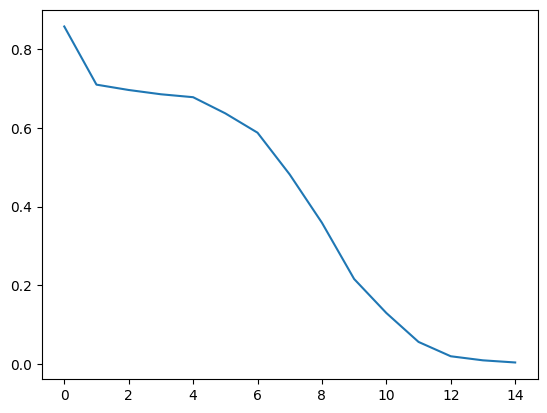

In [121]:
reset_seeds()
fitted_model = model_cat.fit(X_train_cat, y_train_cat, epochs=15, batch_size=32, callbacks=cb)
pd.Series(fitted_model.history['loss']).plot(label='train')

#### Dog model

In [144]:
model_dog = keras.Sequential([
    layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [145]:
model_dog.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dog.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 97, 97, 16)        784       
                                                                 
 conv2d_44 (Conv2D)          (None, 94, 94, 16)        4112      
                                                                 
 conv2d_45 (Conv2D)          (None, 91, 91, 16)        4112      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 16)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 32400)             0         
                                                                 
 dense_32 (Dense)            (None, 64)                2073664   
                                                     

Epoch 1/10
6/6 [==============================] - 3s 332ms/step - loss: 0.8826 - accuracy: 0.5161
Epoch 2/10
6/6 [==============================] - 2s 330ms/step - loss: 0.6908 - accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 2s 309ms/step - loss: 0.6819 - accuracy: 0.6075
Epoch 4/10
6/6 [==============================] - 2s 304ms/step - loss: 0.6414 - accuracy: 0.6559
Epoch 5/10
6/6 [==============================] - 2s 303ms/step - loss: 0.5655 - accuracy: 0.7849
Epoch 6/10
6/6 [==============================] - 2s 300ms/step - loss: 0.4174 - accuracy: 0.8548
Epoch 7/10
6/6 [==============================] - 2s 300ms/step - loss: 0.2781 - accuracy: 0.9247
Epoch 8/10
6/6 [==============================] - 2s 323ms/step - loss: 0.2396 - accuracy: 0.9032
Epoch 9/10
6/6 [==============================] - 2s 296ms/step - loss: 0.1869 - accuracy: 0.9570
Epoch 10/10
6/6 [==============================] - 2s 335ms/step - loss: 0.1098 - accuracy: 0.9677


<Axes: >

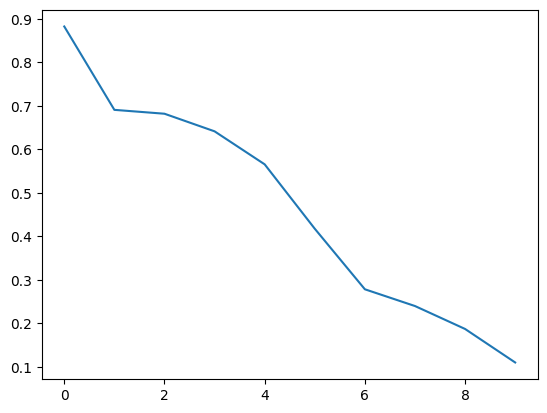

In [146]:
reset_seeds()
fitted_model = model_dog.fit(X_train_dog, y_train_dog, epochs=10, batch_size=32, callbacks=cb)
pd.Series(fitted_model.history['loss']).plot(label='train')

#### Combine 2 models

In [147]:
input_layer = tf.keras.layers.Input(shape=(100, 100, 3))

output_cat = model_cat(input_layer)
output_dog = model_dog(input_layer)

catdog_model = tf.keras.layers.concatenate([output_cat, output_dog])

catdog_model = tf.keras.Model(inputs=input_layer, outputs=catdog_model)

### Test

In [148]:
cats = X_train_cat[y_train_cat==1][0:5]
predictions_cat = catdog_model.predict(cats)
predictions_cat

1/1 [==============================] - 0s 126ms/step


array([[0.9979362 , 0.9043337 ],
       [0.98559386, 0.2096348 ],
       [0.99960953, 0.18951839],
       [0.99826056, 0.5439515 ],
       [0.996877  , 0.5309384 ]], dtype=float32)

In [149]:
dogs = X_train_dog[y_train_dog==1][0:5]
predictions_dog = catdog_model.predict(dogs)
predictions_dog

1/1 [==============================] - 0s 33ms/step


array([[0.7540792 , 0.9994534 ],
       [0.28688625, 0.9771183 ],
       [0.36018085, 0.99980253],
       [0.34143975, 0.8698051 ],
       [0.39139467, 0.9945828 ]], dtype=float32)

In [150]:
# Compare the predictions
for i in range(len(predictions_cat)):
    prediction_cat, prediction_dog = predictions_cat[i]
    thr = 0.8
    dog_class = 1 if prediction_dog > thr else 0
    cat_class = 1 if prediction_cat > thr else 0
    print(i)
    if dog_class == 1 and cat_class == 1:
        print("Both models predict it's a dog and a cat")
    elif dog_class == 1:
        print("Model_dog predicts it's a dog")
    elif cat_class == 1:
        print("Model_cat predicts it's a cat")
    else:
        print("Both models predict it's neither a dog nor a cat")


0
Both models predict it's a dog and a cat
1
Model_cat predicts it's a cat
2
Model_cat predicts it's a cat
3
Model_cat predicts it's a cat
4
Model_cat predicts it's a cat


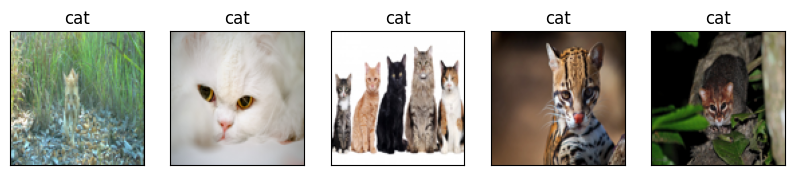

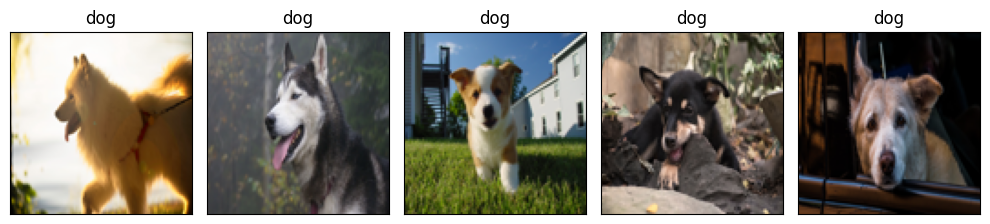

In [88]:
f, a = plt.subplots(nrows=1, ncols=5,figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(cats[i])
    ax.set_title('cat')

fd, ad = plt.subplots(nrows=1, ncols=5,figsize=(10, 6),
                      subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(ad.flat):
    ax.imshow(X_train_dog[y_train_dog==1][0:5][i])
    ax.set_title('dog')

plt.tight_layout()
plt.show()

Conclusions:

The results are not good because the training dataset is too small. But as we did this project for educational purposes, we're happy to achieve any metrics, because it's an experiment.